In [1]:
import copy
import os
import collections

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline
import pymatgen.ext.matproj
import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures
import DigitalEcosystem.utils.misc
import DigitalEcosystem.utils.functional
from DigitalEcosystem.utils.misc import matminer_descriptors
from DigitalEcosystem.utils.element_symbols import  noble_gases, f_block_elements, synthetic_elements_in_d_block

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
data_path = "../matproj_parent_eAboveHull/data_with_mp_ids.csv"
data = pd.read_csv(data_path, index_col=0).fillna(0)

In [4]:
rester = pymatgen.ext.matproj.MPRester(api_key=os.getenv("MATERIALS_PROJECT_API_KEY"))

@DigitalEcosystem.utils.functional.except_with_default_value()
def e_above_hull_fuan(matproj_id):
    return DigitalEcosystem.utils.misc.get_e_above_hull(matproj_id, pymatgen_rester=rester)

def e_cohesive_fun(matproj_id, pymatgen_rester=rester):
    return pymatgen_rester.get_cohesive_energy(matproj_id, per_atom=True)

@DigitalEcosystem.utils.functional.except_with_default_value()
def lookup_with_api(matproj_id, pymatgen_rester=rester, prop=''):
    return pymatgen_rester.get_data(matproj_id, prop=prop)[0][prop]

df = data[data['mp_id (unitless)'] != 'no_parent']
for prop in ('energy_per_atom', 'volume', 'formation_energy_per_atom', 'band_gap', 'density'):
    df[f'mp_{prop}'] = df['mp_id (unitless)'].progress_apply(functools.partial(lookup_with_api, prop=prop))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2579/2579 [03:44<00:00, 11.51it/s]


In [5]:
target = ['exfoliation_energy_per_atom (eV/atom)']
reg_cols = [col for col in df.columns if col.startswith("mp") and "unitless" not in col]
reg_cols += ['max:atomic_number', 'min:atomic_number', 'ave:atomic_number', 'e_above_hull', 'ave:num_p_unfilled', 'bandgap (eV)', *matminer_descriptors]
reg_cols += [col for col in df.columns if ":" in col]


x_reg_cols = [col for col in reg_cols if col not in target]

In [6]:
bad_elements = noble_gases + f_block_elements + synthetic_elements_in_d_block

element_mask = df['formula'].apply(lambda string: all([forbidden not in string for forbidden in bad_elements]))

decomposition_mask = df['decomposition_energy (eV/atom)'] < 0.5

exfol_mask = df['exfoliation_energy_per_atom (eV/atom)'] > 0

hull_mask = df['e_above_hull'] <= 0.05


reasonable = df[element_mask & decomposition_mask & exfol_mask & hull_mask].dropna()

train, test = sklearn.model_selection.train_test_split(reasonable[reg_cols + target], test_size=0.1, random_state=RANDOM_SEED)

In [7]:
train_x_regression = np.nan_to_num(train[reg_cols].to_numpy())
train_y_regression = np.nan_to_num(train[target].to_numpy())

test_x_regression = np.nan_to_num(test[reg_cols].to_numpy())
test_y_regression = np.nan_to_num(test[target].to_numpy())

In [8]:
current_regression = None
best_regression = None
def keep_best_regression(study, trial):
    global best_regression
    if study.best_trial == trial:
        best_regression = current_regression

objective_train_x_regression, objective_validation_x_regression, objective_train_y_regression, objective_validation_y_regression = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_regression), train_y_regression, test_size=0.1, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_regression

    params = {

    }

    current_regression = sklearn.pipeline.Pipeline([
        ("Scaler", sklearn.preprocessing.StandardScaler()),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(
            max_depth= trial.suggest_int('max_depth', 1, 100),
            min_child_weight= trial.suggest_float('min_child_weight', 0, 100),
            reg_alpha = trial.suggest_float('alpha', 0, 5),
            reg_lambda = trial.suggest_float('lambda', 0, 5),
            n_estimators=200,
            objective='reg:squarederror',
            random_state=RANDOM_SEED),),
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_regression.fit(X=objective_train_x_regression, y=objective_train_y_regression,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_regression, objective_validation_y_regression]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 20,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_regression,
        y_pred=abs(current_regression.predict(objective_validation_x_regression)),
    )

    return np.sqrt(score)

regression_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=200),
    direction='minimize'
)

regression_study.optimize(func=objective, n_trials=1024, callbacks=[keep_best_regression])

[I 2021-09-21 17:16:22,478] A new study created in memory with name: no-name-ffcf18a6-7c5b-4527-81e5-026cadb13f05
[I 2021-09-21 17:16:22,598] Trial 0 finished with value: 0.0450743157464089 and parameters: {'max_depth': 20, 'min_child_weight': 62.21087710398319, 'alpha': 2.1886386950355723, 'lambda': 3.926792918568846}. Best is trial 0 with value: 0.0450743157464089.
[I 2021-09-21 17:16:22,701] Trial 1 pruned. Trial was pruned at iteration 27.
[I 2021-09-21 17:16:22,717] Trial 2 pruned. Trial was pruned at iteration 3.
[I 2021-09-21 17:16:22,825] Trial 3 finished with value: 0.046405484854999714 and parameters: {'max_depth': 69, 'min_child_weight': 71.27020269829002, 'alpha': 1.8512537739519748, 'lambda': 2.8059809303281247}. Best is trial 0 with value: 0.0450743157464089.
[I 2021-09-21 17:16:23,068] Trial 4 finished with value: 0.07590311163015424 and parameters: {'max_depth': 51, 'min_child_weight': 1.3768449590682241, 'alpha': 3.8641331080618704, 'lambda': 4.413205953180583}. Best i

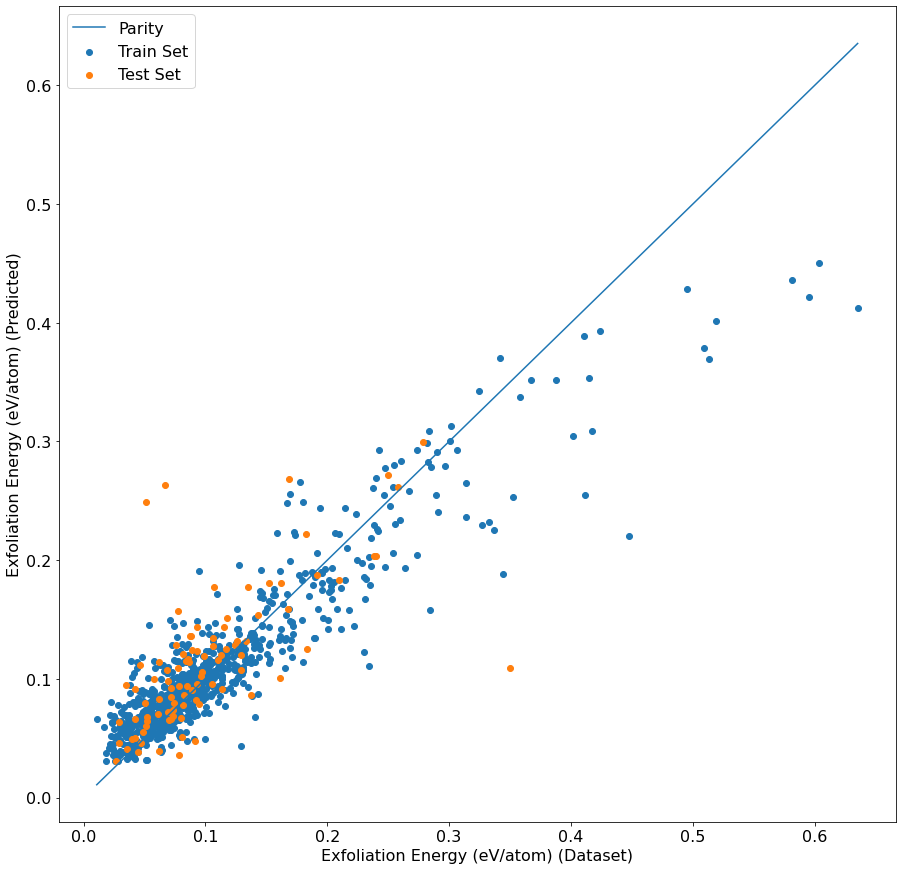

In [9]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x_regression,
                                                test_x_regression,
                                                train_y_regression,
                                                test_y_regression,
                                                best_regression,
                                                "Exfoliation Energy (eV/atom)",
                                                "parity.jpeg")

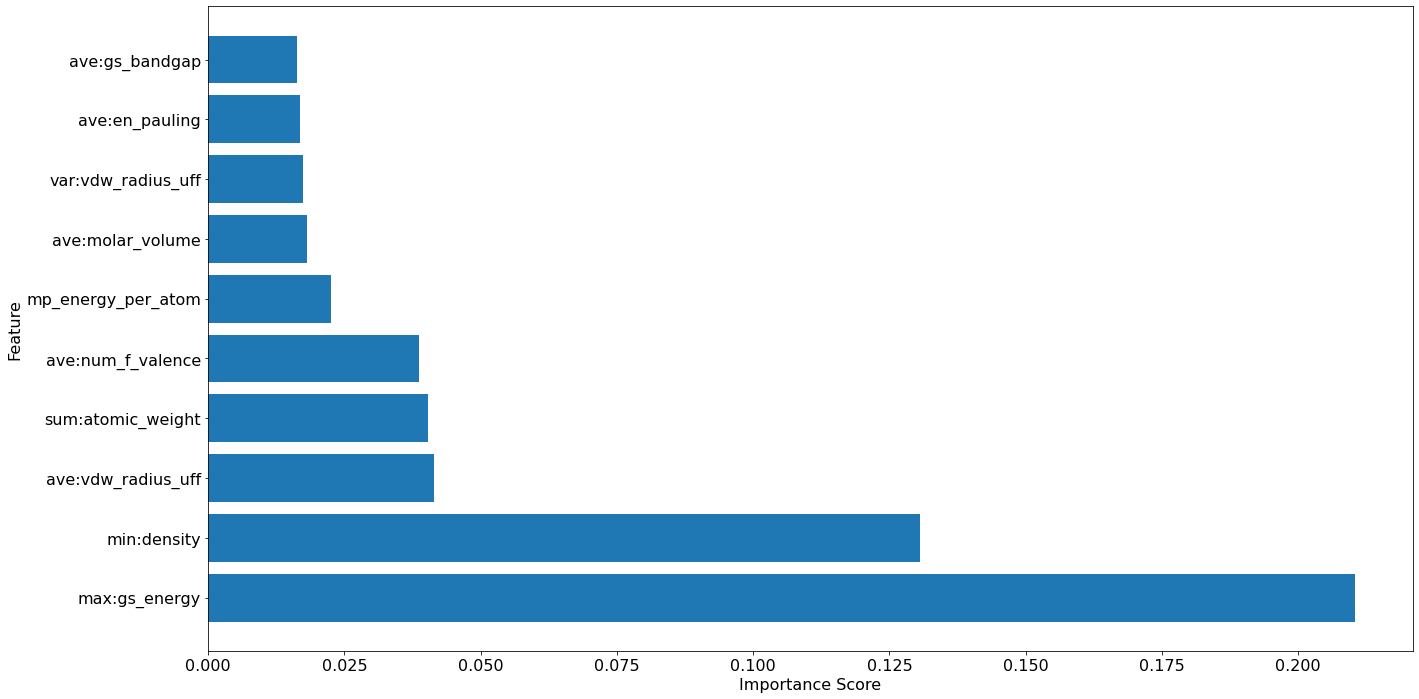

In [10]:
n_importances = 10
importances = list(zip(best_regression[1].feature_importances_, reg_cols))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))


x=10
plt.rcParams['figure.figsize'] = (2*x,x)
plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("Importances.jpeg")

In [11]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_regression.predict(test_x_regression)
print("Test-Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y_regression, y_pred=y_pred_test)
    print(key,np.round(value,3))

Test-Set Error Metrics
MaxError 0.24
MAE 0.03
MSE 0.002
RMSE 0.049
MAPE 0.373
R2 0.31


In [12]:
train['errors'] = (best_regression.predict(train_x_regression).reshape(-1,1)-train_y_regression)**2

In [13]:
train.nlargest(5,['errors'])['bandgap (eV)']

4617    2.8618
3363    3.1512
5408    2.3190
5467    0.0000
3841    1.9150
Name: bandgap (eV), dtype: float64

In [14]:
df.loc[5408]

2dm_id (unitless)                 2dm-5419
Total Angles (angles)                   62
Total Atoms (atoms)                      3
Total Bonds (bonds)                   14.0
alkaine_earth (atoms)                  0.0
                                   ...    
mp_energy_per_atom               -5.699437
mp_volume                       183.632752
mp_formation_energy_per_atom     -2.225874
mp_band_gap                         1.4908
mp_density                        5.731366
Name: 5408, Length: 813, dtype: object